# Agent Based Modelling

[Wikipedia](http://en.Wikipedia.org/wiki/agent-based_model): An agent-based model (ABM) is one of a class of computational models for simulating the actions and interactions of autonomous agents with a view to assessing their effects on the system as a whole.

## How to create an ABM
A simple agent-based model can be build with the following ingredients:

*	__Agents__ that interact with the environment or with each other
*	__A set of rules__ that determines what every agent is allowed or has to do
* __A loop__, which allows to repeatedly act or interact

Here we consider two agents playing a simple game: __Rock, Paper, Scissors__

## Rock Paper Scissors, simple
We start by setting up a data structure to keep tack of the states of our agents:

In [1]:
indDF <- data.frame(id=1:2, strategy=NA, num_wins=0)
indDF

id,strategy,num_wins
1,NA,0
2,NA,0


That's enough to get us started. We have now two individuals that we can identify using their __ID__, they have a __strategy__ (which they haven't chosen yet), and an __indicator for success__, here number of winning turns.

In the next step we need to define some rules to let individuals interact with each other

### First: Every individual chooses a strategy
We started by defining a function that simulates individuals choosing a strategy:

In [2]:
chooseStrategy <- function(ind){
	strats <- sample(x=1:3, size=nrow(ind)) # 1:Paper, 2:Scissors, 3:Rock
	ind$strategy <- strats
	return(ind)
}

### Second: Individuals play their strategies
Next, we write a function that evaluates the strategy choices of both agents and increases the win counter for the successful individual (or does nothing in case of a tie).

In [3]:
playStrategy <- function(ind){
		if(ind$strategy[1]==ind$strategy[2]) {} else{
			#in the case that one chose Rock and the other paper:
			if(any(ind$strategy == 3) && any(ind$strategy == 1)){ 
				tmp <- which(ind$strategy==1)
				ind[tmp,"num_wins"] <- ind[tmp,"num_wins"]+1
			}else{
				#for the two other cases, the better weapon wins:
				tmp <- ifelse(test = indDF[1,"strategy"]>indDF[2,"strategy"], yes=1, no=2)
                # Alternative: tmp <- which.max(indDF[,"strategy"])
				ind[tmp,"num_wins"] <- ind[tmp,"num_wins"]+1 
			}
		}
	return(ind)
}

### Third: Let's loop it
We have all ingridients for a simulation. What we need to do now is to let our agents choose a strategy and play their strategy against each other repeatedly:

In [4]:
# indDF <- setup()
for(i in 1:1000){
	indDF <- chooseStrategy(indDF)#; indDF
	indDF <- playStrategy(indDF)#; indDF
	};indDF

id,strategy,num_wins
1,1,501
2,2,499


At some point it might be handy to have a function that initialises our game:

In [5]:
setup <- function(){
	return(data.frame(id=1:2, strategy=NA, num_wins=0))
}

Congratulations, we made it. 

You might have noticed, that we only see the final result but do not retrieve any intermediate results. How can we monitor what happens throughout the simulatinos to get a better feeling of the dynamics? Here, we will simply return the number of wins in every round and store these in an additional data structure, `dat`:

In [6]:
rounds <- 1000
indDF <- setup()
dat <- matrix(NA, rounds, 2)
for(i in 1:rounds){
	indDF <- chooseStrategy(indDF)
	indDF <- playStrategy(indDF)
	dat[i,] <- indDF$num_wins
	}

Now, we have time data, which we can plot:

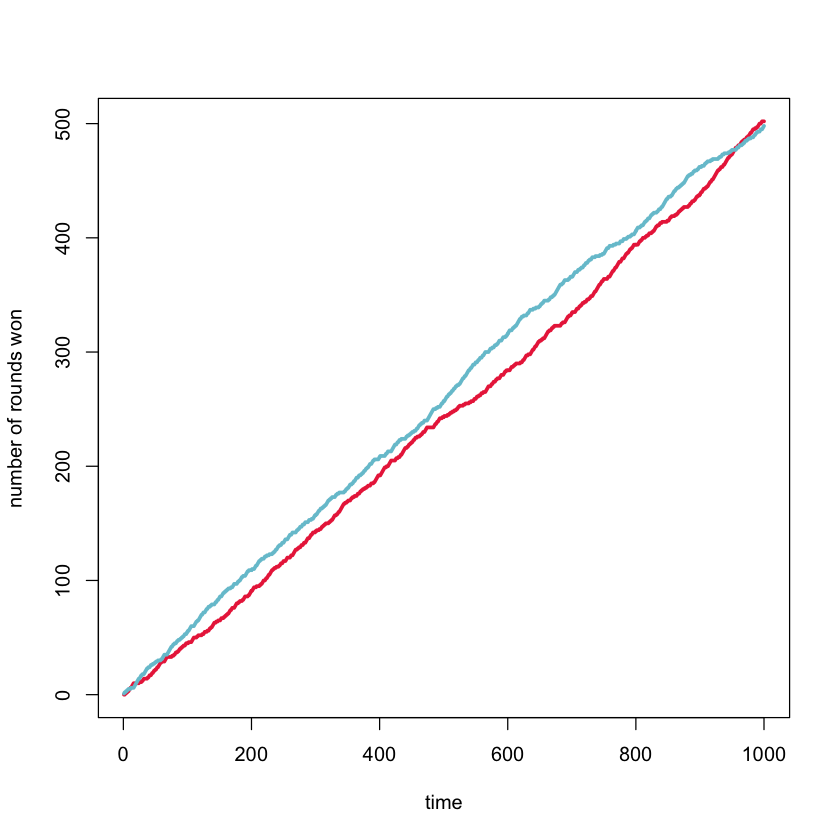

In [7]:
plot(dat[,1], type='l', col='#EA2E49', lwd=3, xlab='time', ylab='number of rounds won')
lines(dat[,2], col='#77C4D3', lwd=3)

## Strategy switcher versus strategy keeper

Now that we have a working toy model, let's think about something more interesting that we could do with it. For example, we could test the hypothesis that _a player that never switches its strategy is more successful than an individual that randomly chooses a strategy in every turn_?

To test this we need to adjust our model. Specifically, the function that describes strategy choosing.

In [8]:
chooseStrategy2 <- function(ind){
	strats <- sample(x=1:3, size=1) # 1:Paper, 2:Scissors, 3:Rock
	ind$strategy[2] <- strats
	return(ind)
}

The change to the `chooseStrategy()` function causes the second individual to change its strategy, while the first chooses a strategy once and then sticks with it.

In [9]:
rounds <- 1000
repetitions <- 100
dat <- matrix(NA, rounds, 2)
res2 <- c()
for(j in 1:repetitions){
	indDF <- setup()
	indDF[1,"strategy"] <- sample(1:3,1) # Individual 1 chooses a strategy
	for(i in 1:rounds){
		indDF <- chooseStrategy2(indDF)
		indDF <- playStrategy(indDF)
		dat[i,] <- indDF$num_wins
	}
		res2 <- c(res2, which.max(indDF[,"num_wins"]) )
}

Let's have a look at how often individual 1 (chooses strategy once and then sticks with it) wins against individual 2 (chooses a strategy randomly in every turn):

In [10]:
table(res2)

res2
 1  2 
51 49 

There seems to be no clear difference between the two strategies. Let's have a look at the time data of the simulation:

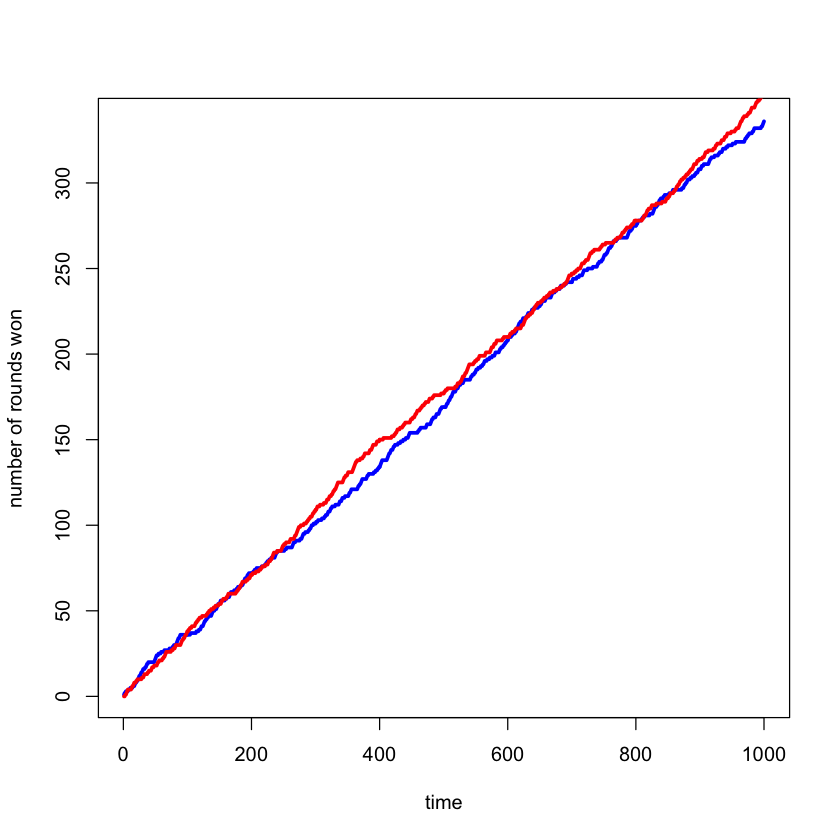

In [11]:
plot(dat[,1], type='l', col='blue', lwd=3, xlab='time', ylab='number of rounds won')
lines(dat[,2], col='red', lwd=3)

You might have noticed that this plot is only showing the very last simulation run of our 100 repetitions. 

How can we plot all of the runs? Well, to do that, we need to record all of these runs. That's what we are doing in the next step:

In [12]:
rounds <- 100
repetitions <- 100
dat_time <- data.frame(s1=rep(NA, rounds*repetitions), s2=rep(NA, rounds*repetitions))
k <- 1
for(j in 1:repetitions){
	indDF <- setup()
	indDF[1,"strategy"] <- sample(1:3,1)
	for(i in 1:rounds){
		indDF <- chooseStrategy2(indDF)
		indDF <- playStrategy(indDF)
		dat_time[k,] <- indDF$num_wins
        k <- k+1
	}
}

With the code above we run several instances of the code in parallel using the `lapply()` function. This function returns a list of elements, where each element is the result of a single simulation instance. To better work with the data we collapse the data into a single matrix (using the `do.call(rbind` function), and then add a round identifier and an instance identifier in the next step:

In [13]:
dat_time$round <- 1:rounds
dat_time$identifier <- rep(1:repetitions, each=rounds) 

library(reshape2)
dat_time_m <- melt(data=dat_time, id.vars=c("round","identifier")) # change data from wide to long representation

Finally, we can plot the data using the `ggplot2` library. (I also use the `cowplot` library to make the standard ggplot figure look nicer):

Warning message:
“package ‘cowplot’ was built under R version 3.5.2”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


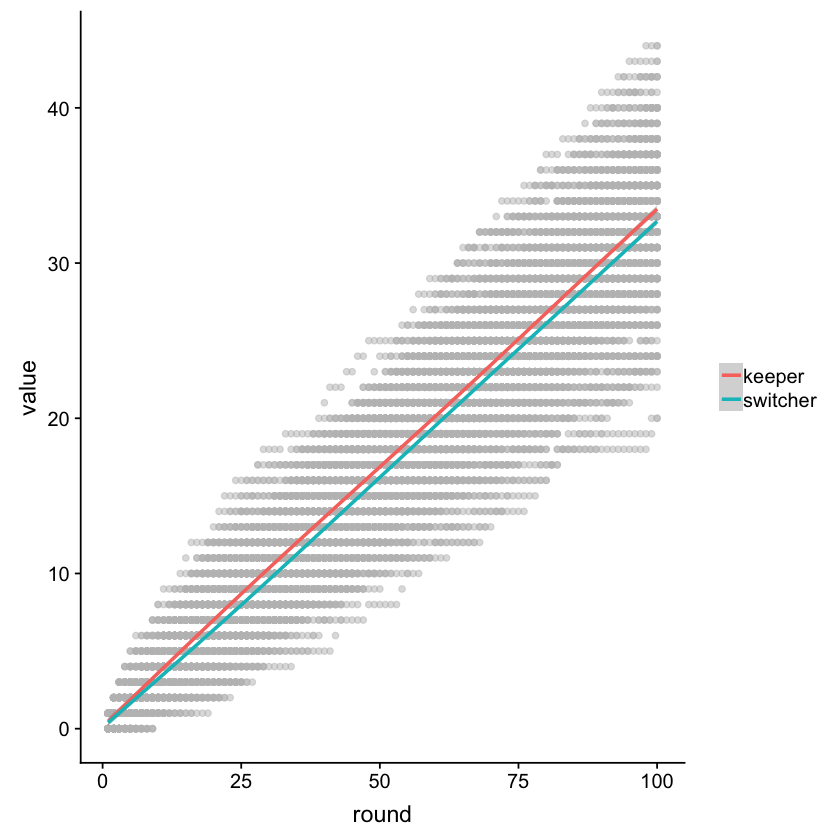

In [14]:
library(ggplot2); library(cowplot) 
ggplot(dat_time_m) + 
  geom_point(aes(x=round, y=value), colour="grey", alpha=.5) + 
  geom_smooth(aes(x=round, y=value, colour=factor(variable, levels=c("s1","s2"), labels=c("keeper","switcher")))) + 
  theme(legend.title=element_blank())

In [15]:
# for comparisson let's calculate the winning vector for both players switch strategies:
res1 <- c()
for(j in 1:repetitions){
	indDF <- setup()
	for(i in 1:rounds){
		indDF <- chooseStrategy(indDF)
		indDF <- playStrategy(indDF)
		dat[i,] <- indDF$num_wins
		i <- i+1
	}
		res1 <- c(res1, which.max(indDF[,"num_wins"]) )
		j <- j+1
}
# and the winner is:
t.test(res1,res2)


	Welch Two Sample t-test

data:  res1 and res2
t = -0.56432, df = 198, p-value = 0.5732
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.17978035  0.09978035
sample estimates:
mean of x mean of y 
     1.45      1.49 


We now can answer our initial question, whether there is a difference between sticking with your strategy or switching. There answer is no, it doesn't make a difference. One less question to ponder over. 

However, it is important to understand that for the case where we run many simulations with many rounds we could have also simply asked for the probability that one strategy wins over the other. Because we assume that the individual that switches its strategy chooses a new strategy randomly, it will play each strategy with a 33% probability. Therefore, there will be a tie with the other player in 33% of the cases, a win in 33% and a loss in 33% of the cases. The same is true for the other player. So, given that individuals play often enough, there can not be a difference. 



## Rock, Paper, Scissors  - on a network
In this second example we are going to use the same game, but this time several individuals will play against each other. To make it more interesting individuals are organised on a lattice network. Thus, they can only play with their direct neighbors. A loser will copy the strategy of the winner. The question is, what are the strategy dynamics over time and in relation to the network configuration. (You can see this as a very simple example of an evolutionary process)

Loading required package: igraph
Warning message:
“package ‘igraph’ was built under R version 3.5.2”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



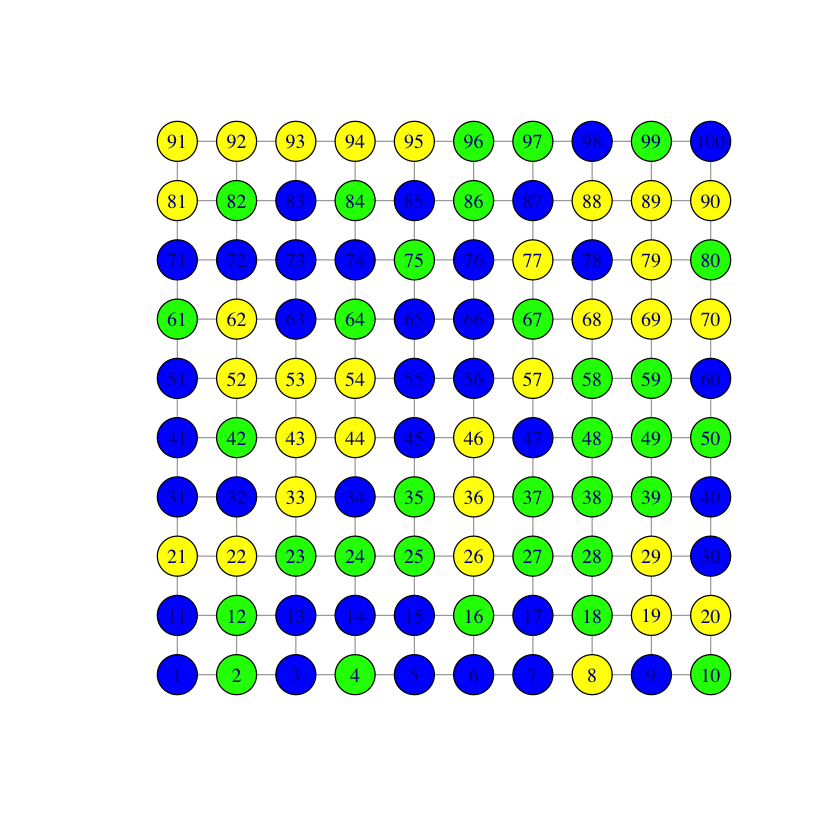

In [16]:
require(igraph)
require(reshape2)
require(ggplot2)

# size of the lattice
sidelength <- 10 

# creating an empty data.frame to store data
stat <- data.frame()

# creating a lattice network using the igraph package
l <- graph.lattice(length=sidelength,dim=2)

# now every individual chooses a strategy at random
V(l)$weapon <- sample(c(1:3), size=length(V(l)), replace=T)

# for a nicer visualisation lets colour the different options
V(l)[weapon==1]$color <- 'blue' # Paper
V(l)[weapon==2]$color <- 'yellow' # Scissors
V(l)[weapon==3]$color <- 'green' # Rock

# and this is what it looks like:
plot(l, layout=as.matrix(expand.grid(1:sidelength, 1:sidelength)) ) #, vertex.label=NA

In [17]:
for(t in 1:3500){
	# pick a random agent ...
	from <- sample(sidelength^2,1)
	# who are its neighbours?
	nei <- neighbors(l, v=from, mode='all')
	
	# if there is only one weapon type left
	if(length(unique(V(l)$weapon))==1) {
		# we can either stop the simulation
		stop(paste(c('Paper','Scissors','Rock')[unique(V(l)$weapon)], 'has won the game after',t,'rounds!'))
		# or we let the selected individual choose a different strategy to let the dynamics go on
		# V(l)$weapon[from]<-sample((1:3)[1:3!=as.numeric(V(l)$weapon[from])], 1)
	} else {
		# ... and one of its neighbours
		to <- sample(nei, 1) 
		fromto <- c(from,to)
		w<-as.numeric(V(l)$weapon[fromto])
		# if both choices are equal, nothing happens:
		if(w[1]==w[2]) {} else{ 
			# in the case that one chooses Rock and the other Paper, Paper wins:
			if(max(w) == 3 && min(w) ==1) { 
				V(l)$weapon[fromto[w==3]] <- "1" 
			} 
			else{
				# for the two other cases, the better weapon wins:
				V(l)$weapon[fromto[w==min(w)]] <- V(l)$weapon[fromto[w==max(w)]]
			}
		} 
		
	}
	# let's record the individual abundance of each strategy
	stat <- rbind(stat, c(sum(V(l)$'weapon'=="1"), sum(V(l)$'weapon'=="2"), sum(V(l)$'weapon'=="3")))
	# plot(l, layout=as.matrix(expand.grid(1:sidelength, 1:sidelength)), vertex.label=NA)
}

ERROR: Error in eval(expr, envir, enclos): NA has won the game after 3344 rounds!


No id variables; using all as measure variables


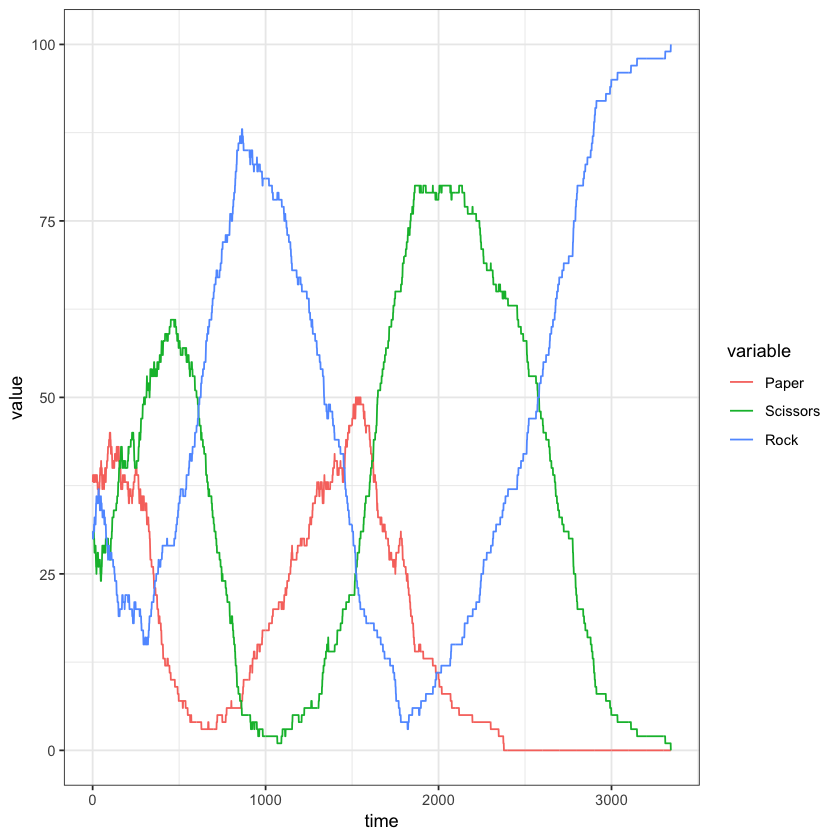

In [18]:
names(stat)<-c("Paper","Scissors","Rock")
s<-melt(stat)
s$time<-1:nrow(stat)
ggplot(data=s, mapping=aes(x=time, y=value, col=variable)) + geom_line() + theme_bw() 

## And what is with Spock?
You might have heard of an extension to the classic game, adding **Spock** and **Lizard**.
![link](https://d3qdvvkm3r2z1i.cloudfront.net/media/catalog/product/cache/1/image/1800x/6b9ffbf72458f4fd2d3cb995d92e8889/r/o/rockpaperscissorslizardspock_newthumb.png)

With the model above it is very easy for example to add a further strategy. How about adding Spock to the game?

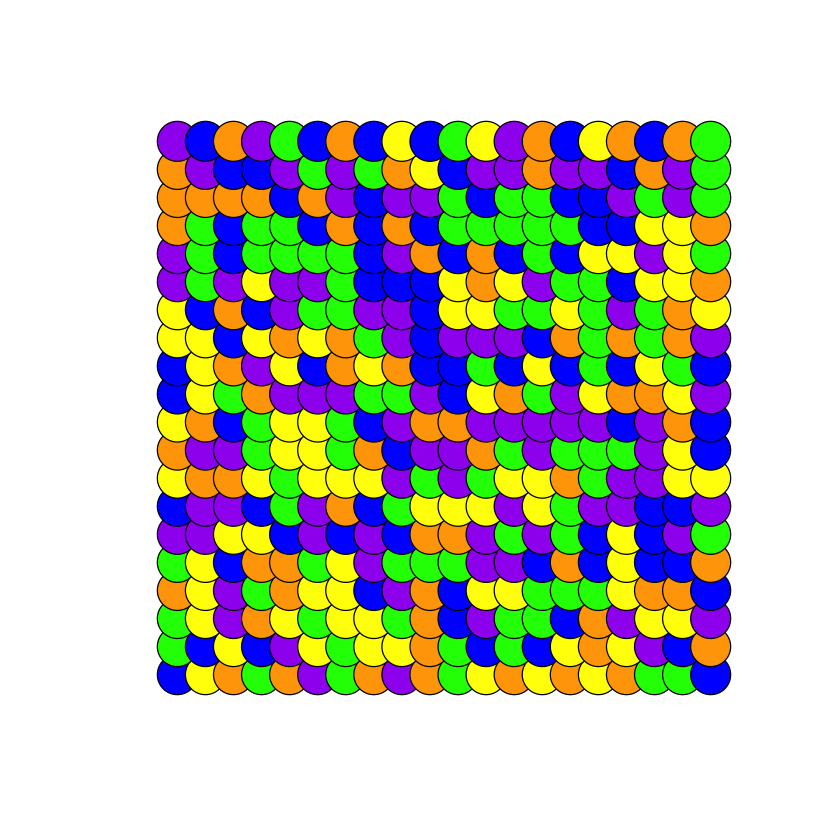

In [19]:
# size of the lattice
sidelength<-20 
# creating an empty data.frame to store data
stat<-data.frame()
# creating a lattice network using the igraph package
l<-graph.lattice(length=sidelength,dim=2)
# now every individual chooses a strategy at random
V(l)$weapon<-sample(c(1,2,2.1,2.9,3), size=length(V(l)), replace=T)
# for a nicer visualisation lets colour the different options
V(l)[weapon==1]$color<-'blue' # Paper
V(l)[weapon==2]$color<-'yellow' # Scissors
V(l)[weapon==3]$color<-'green' # Rock
V(l)[weapon==2.9]$color<-'purple' # Spock
V(l)[weapon==2.1]$color<-'orange' # Lizard
# and this is what it looks like:
plot(l, layout=as.matrix(expand.grid(1:sidelength, 1:sidelength)), vertex.label=NA)

In [20]:

for(t in 1:3000){
	# pick a random agent ...
	from <- sample(sidelength^2,1)
	# who are its neighbours?
	nei <- neighbors(l, v=from, mode='all')
	
	# if there is only one weapon type left
	if(length(unique(V(l)$weapon))==1) {
		# we can either stop the simulation
		stop(paste(c('Paper','Scissors','Lizard','Spock','Rock')[unique(V(l)$weapon)], 'has won the game after',t,'rounds!'))
		# or we let the selected individual choose a different strategy to let the dynamics go on
		# V(l)$weapon[from]<-sample((1:3)[1:3!=as.numeric(V(l)$weapon[from])], 1)
	} else {
		# ... and one of its neighbours
		to <- sample(nei, 1) 
		fromto<-c(from,to)
		w<-as.numeric(V(l)$weapon[fromto])
		# if both choices are equal, nothing happens:
		if(w[1]==w[2]) {} else{ 
			# in the case that one chooses Rock and the other Paper, Paper wins:
			if(max(w) == 3 && min(w) ==1) { 
				V(l)$weapon[fromto[w==3]] <- "1" 
			} 
			else{
				# for the two other cases, the better weapon wins:
				V(l)$weapon[fromto[w==min(w)]] <- V(l)$weapon[fromto[w==max(w)]]
			}
		} 
		
	}
	# let's record the individual abundance of each strategy
	stat<-rbind(stat, c(sum(V(l)$'weapon'=="1"), sum(V(l)$'weapon'=="2"), sum(V(l)$'weapon'=="2.1"), sum(V(l)$'weapon'=="2.9"), sum(V(l)$'weapon'=="3")))
	# you can also plot each individual network configuration in each simulation step (careful, this will considerably slow down execution!)
	# V(l)[weapon==1]$color<-'blue' # Paper
	# V(l)[weapon==2]$color<-'yellow' # Scissors
	# V(l)[weapon==3]$color<-'green' # Rock
	# V(l)[weapon==2.9]$color<-'purple' # Spock
    # V(l)[weapon==2.1]$color<-'orange' # Lizard
	# plot(l, layout=as.matrix(expand.grid(1:sidelength, 1:sidelength)), vertex.label=NA)
}

No id variables; using all as measure variables


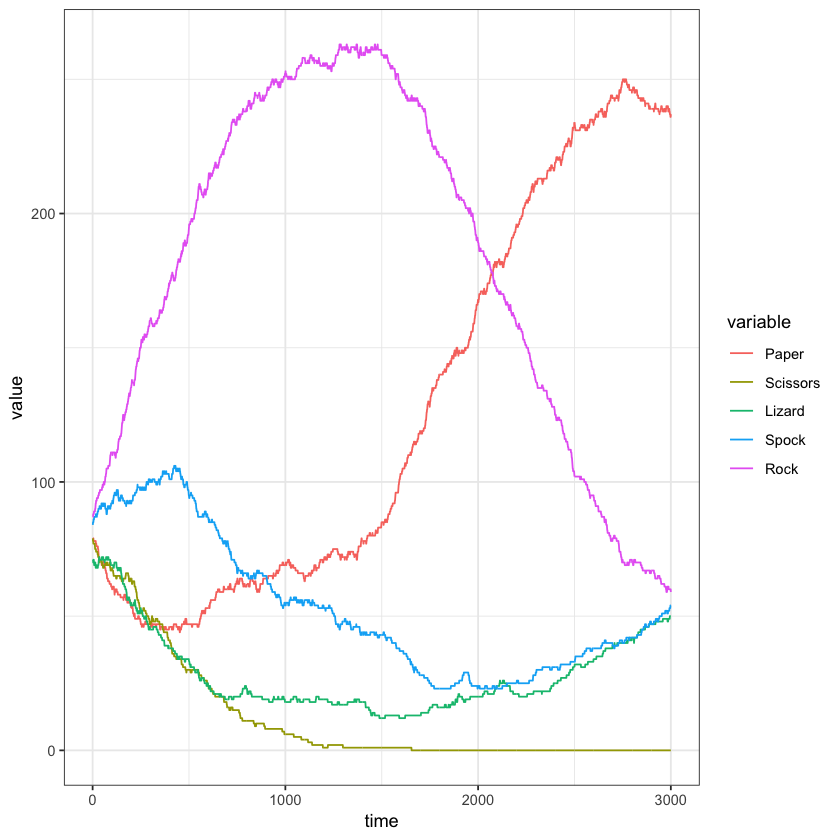

In [21]:
names(stat)<-c("Paper","Scissors","Lizard","Spock","Rock")
s<-melt(stat)
s$time<-1:nrow(stat)
ggplot(data=s, mapping=aes(x=time, y=value, col=variable)) + geom_line() + theme_bw() 

With the current network configuration (connectivity and size) we find that two strategies often are lost from the population very early on in the simulation. How would these results look different with a larger network? (try sidelenght=20 and 5000 steps)

### Homework
We have not create a very simple agent-based simulation. However, this model could be a lot more interesting, for example, to investigate the effect of different network topologies on the strategy dynamics in the network. 

Change the above model to use random graphs and scale-free networks instead of the simple lattice network. Scale-free networks are controlled by two parameters $k$ (degree), and $\gamma$ (preferential attachment). Random graphs can be controlled by the parameters $m$ (total number of edges) and $n$ (the number of nodes). 

For the scale-free version change $\gamma$ and observe how this changes the strategy dynamics. Can you explain what happens for larger and small values of $\gamma$? 

For the random graphs version vary the number of edges and observe how this changes the strategy dynamics. How are these results related to the those you observed for the scale-free version? 

Note: when you create random graphs there is a chance that you will receive unconnected nodes (i.e. having no neighbours). You need to consider this in your model. Find a way to deal with unconnected nodes and justify your decision. 